# Análise de dados do Juizado Especial Federal do Rio Grande do Norte

## Inicialização dos dataframes

In [0]:
# Conexão com o google drive
from google.colab import drive
drive.mount('/content/drive',force_remount=True)

In [0]:
# Instalando unidecode 
pip install unidecode

In [0]:
# Bibliotecas
import pandas as pd
import sqlite3
import matplotlib.pyplot as plt
import numpy as np
import re
import seaborn as sns
import plotly.graph_objects as go
import plotly.express as px
from wordcloud import WordCloud 
import folium
import json
import os
import networkx as nx
import itertools
from unidecode import unidecode

In [0]:
# Acessando os arquivos presentes no zip 'CRETA.sqlite3.zip'
!unzip /content/drive/"My Drive"/CRETA.sqlite3.zip

In [0]:
# Estabelecendo conexão com o banco de dados sqlite3 'CRETA.sqlite3'
conn = sqlite3.connect('CRETA.sqlite3') 

In [0]:
# Tabela 'processos'
processos = pd.read_sql_query('SELECT * FROM processos', conn)

In [0]:
# Tabela 'assuntos'
assuntos = pd.read_sql_query('SELECT * FROM assuntos', conn)

In [0]:
# Tabela 'movimentacoes'
movimentacoes = pd.read_sql_query('SELECT * FROM movimentacoes', conn)

In [0]:
# Fechando conexão com o banco de dados
conn.close()

In [0]:
# Acessando o arquivo que contém as varas federais dos processos
varas = pd.read_csv("/content/drive/My Drive/Datasets Extras [IC]/procs_com_varas.csv")

In [0]:
# Acessando as entidades presentes no escopo de réus do Juizado Especial Federal
with open('/content/drive/My Drive/Datasets Extras [IC]/entidades.txt', 'r') as filehandle:
    entidades = json.load(filehandle)

## Funções criadas especificamente para este processo de análise de dados

Uma etapa essencial do processo de análise de dados é a limpeza e tratamento de inconsistências presentes, com o intuito de que as informações apresentadas nos resultados sejam os mais precisos possíveis e coerentes com o escopo tratado.

Diante disso, tanto neste tópico de criação de funções customizadas quanto no próximo de limpeza de dados, é implementado o que foi descrito acima.

In [0]:
# Função para redefinir os detalhes dos processos durante a limpeza inicial da tabela
def new_structure(string):
  manter_siglas = ['DIB','FGTS','RMI','IRPF','IPMF','ITR','IPTU','IRPJ','IOC/IOF','IPI','CADIN','CPF','REFIS',
                   'AIDF','ISS','CNPJ','PAES','DIMOB', 'CNH','II'] 

  for sigla in manter_siglas:
    if string.find(sigla) > -1:
      return sigla

  if string.find('Auxílio-Doença') > -1:
    return "_".join(['AD',string.split('Auxílio-Doença')[1].strip()])

  if string == 'Seguro Desemprego':
    return 'Seguro-desemprego'

  if string.find('Contrato Temporário de Mão de Obra') > -1:
    return string.split('L')[0].strip()

  if string == 'PIS - Indenização':
    return 'PIS'

  string = string.split('(')[0]
  string = string.replace(', ','_')
  string = string.replace(' - ','_')
  string = string.replace('-','_')
  string = string.replace(' / ','/')
  string = string.strip()
  string = string.replace(' ','_')
  return string

Diante da necessidade de padronizar a forma como os detalhes dos assuntos pertinentes aos processos são apresentados, para posterior criação de gráficos, foi criada a função *new_structure*. Esta é responsável, por exemplo, por manter siglas conhecidas, como FGTS e CNPJ, ao invés de descrições extensas, assim como uniformizar a separação entre palavras com o uso de caracteres no lugar de espaçamentos.

In [0]:
# Função para excluir falsos autores ou réus registrados nos processo
def detectar_real(ent,tipo):
  identificadores = ['AC','AL','AP','AM','BA','CE','DF','ES','GO','MA','MT','MS','MG','PA','PB','PR','PE','PI','RJ',
                     'RN','RS','RO','RR','SC','SP','SE','TO']

  if tipo == 'reu':
    if any(nome == ent for nome in entidades):
      return True
    else: 
      return False

  if ent.find('PROCURADORIA FEDERAL') > -1:
    return False
  elif ent == 'NENHUMA PARTE CADASTRADA':
    return False
  elif ent.find('()') > -1:
    return False
  elif ent.split('(')[1][:2] in identificadores:
    return False
  elif ent.find('(00.000.000/0000-00)') > -1:
    return False
  elif ent.find('(00.100.200/3000-04)') > -1:
    return False
  else:
    return True

Considerando que os advogados tendém a ser registrados com seus respectivos autores e réus, foi necessário promover uma limpeza dos dados de forma que esses casos sejam descartados das análises. Para isso, observou-se que advogados são, geralmente, acompanhados de um identificador da UF, logo, tal dado foi utilizado como marcador, na função *detectar_real*, de que o ente não deve ser considerado.

O registro dos réus possui casos em que foram mantidas as entidades representativas que acompanham instituições públicas para pagamento dos custos provenientes da sentença na ocasião da perda judicial, os quais não devem ser observados como réus. Os sinalizadores considerados foram os seguintes: identificadores que contém apenas zeros e o identificador '00.100.200/3000-04', o qual é referente ao EADJ (Equipe de atendimento de demandas judiciais), o qual é responsável por acompanhar o INSS durante o processo, com o objetivo de realizar o cumprimento financeiro da sentença em caso de perda.

Além disso, por não integrar o escopo tratado, a Procuradoria Federal também foi excluída.

In [0]:
# Função para extrair a denominação do réu
def extrair_nome(string):
  try:
    string = string.split('(',maxsplit=1)[0]
  except:
    pass 

  try:
    string = string.split('-',maxsplit=1)[0]
  except:
    pass 
  return string.strip()

A função *extrair_nome*, como sugerido pela nomeação, serve para obter os nomes dos réus, os quais serão utilizados em diversas das análises realizadas.

In [0]:
# Função para gerar combinações dentre um grupo de elementos que serão tomados dois a dois 
def combinacoes(grupo,list_associacoes):
  for subset in itertools.combinations(grupo, 2):
    list_associacoes.append(subset)

A função *combinacoes* permite identificar associações, de dois elementos, dentre um grupo proposto, similarmente ao conceito de Combinação Simples aplicado na área da Matemática.

In [0]:
# Função para extrair o identificador da vara federal
def extrair_identificador(string):
  string = string.split('a.')[0]
  return string

Com o objetivo de apenas usar o identificar numérico como sinalizador da vara federal, a função *extrair_identificador* permite desconsiderar a descrição posterior aos algarismos.

In [0]:
# Função que retornará os municípios que compõem uma específica vara federal
def selecionar_municipios(id_vara):
  # Natal
  if id_vara in ['3','7']:
    vara_natal = ['Natal','Extremoz','Arês','Baía Formosa','Barcelona','Bom Jesus','Brejinho',
                  'Caiçara do Rio do Vento','Campo Redondo','Canguaretama','Coronel Ezequiel',
                  'Parnamirim','Espírito Santo','Goianinha','Jaçanã','Januário Cicco','Japi',
                  'Jundiá',"Lagoa d'Anta",'Lagoa de Pedras','Lagoa de Velhos','Lagoa Salgada',
                  'Lajes Pintadas','Macaíba','Montanhas','Monte Alegre','Monte das Gameleiras',
                  'Nísia Floresta','Nova Cruz','Passa e Fica','Passagem','Santa Maria','Pedro Velho',
                  'Presidente Juscelino','Riachuelo','Ruy Barbosa','Santa Cruz','Santo Antônio',
                  'São Bento do Trairí','São Gonçalo do Amarante','São José de Mipibu',
                  'São José do Campestre','São Paulo do Potengi','São Pedro','São Tomé',
                  'Senador Elói de Souza','Senador Georgino Avelino','Serra de São Bento',
                  'Serrinha','Sítio Novo','Tangará','Tibau do Sul','Várzea','Vera Cruz','Vila Flor']
    return vara_natal
  # Mossoró
  elif id_vara in ['8','10','13']:
    vara_mossoro = ['Mossoró','Apodi','Areia Branca','Baraúna','Caraúbas','Felipe Guerra',
                    'Governador Dix-Sept Rosado','Grossos','Janduís','Porto do Mangue',
                    'Tibau','Serra do Mel','Upanema']
    return vara_mossoro
  # Caicó
  elif id_vara == '9':
    vara_caico = ['Caicó','Acari','Carnaúba dos Dantas','Cerro Corá','Cruzeta','Currais Novos','Equador',
                  'Florânia','Ipueira','Jardim de Piranhas','Jardim do Seridó','Jucurutu',
                  'Lagoa Nova','Ouro Branco','Parelhas','Santana do Seridó','São Fernando','São João do Sabugi',
                  'São José do Seridó','São Vicente','Serra Negra do Norte','Tenente Laurentino Cruz',
                  'Timbaúba dos Batistas']
    return vara_caico
  # Açú
  elif id_vara == '11':
    vara_acu = ['Açu','Afonso Bezerra','Alto do Rodrigues','Angicos','Augusto Severo',
                'Bodó','Carnaubais','Fernando Pedroza','Galinhos','Guamaré','Ipanguaçu','Itajá','Lajes',
                'Macau','Paraú','Pedro Avelino','Pendências','Santana do Matos','São Rafael',
                'Triunfo Potiguar']
    return vara_acu
  # Pau dos Ferros
  elif id_vara == '12':
    vara_pau_dos_ferros = ['Pau dos Ferros','Água Nova','Alexandria','Almino Afonso','Coronel João Pessoa',
                          'Doutor Severiano','Encanto','Francisco Dantas','Frutuoso Gomes','Itaú','João Dias',
                          'José da Penha','Lucrécia','Luís Gomes','Major Sales','Marcelino Vieira','Martins',
                          'Messias Targino',"Olho-d'Água do Borges",'Paraná','Patu','Pilões','Portalegre',
                          'Rafael Fernandes','Rafael Godeiro','Riacho da Cruz','Riacho de Santana',
                          'Rodolfo Fernandes','São Francisco do Oeste','São Miguel','Serrinha dos Pintos',
                          'Severiano Melo','Taboleiro Grande','Tenente Ananias','Umarizal','Venha-Ver',
                          'Viçosa','Antônio Martins']
    return vara_pau_dos_ferros
  # Ceará Mirim
  else:
    vara_ceara_mirim = ['Ceará-Mirim','Bento Fernandes','Caiçara do Norte','Ielmo Marinho','Jardim de Angicos',
                        'João Câmara','Maxaranguape','Parazinho','Rio do Fogo','Pedra Grande','Pedra Preta',
                        'Poço Branco','Pureza','São Bento do Norte','São Miguel do Gostoso','Taipu',
                        'Touros','Jandaíra']
    return vara_ceara_mirim

A função *selecionar_municipios* é voltada para conceder os respectivos municípios de uma vara federal, conforme o indeficador apresentado.

In [0]:
# Função para acessar a quantidade de linhas correspondentes a uma específica vara federal
def vara_quantidades(df_varas,id_vara,list_transicao):
  # Natal
  if id_vara in ['3','7']:
    list_transicao.extend(['3','7'])
    return df_varas[df_varas['vara'].str.contains('|'.join(['3','7']))].shape[0]
  # Mossoró
  elif id_vara in ['8','10','13']:
    list_transicao.extend(['8','10','13'])
    return df_varas[df_varas['vara'].str.contains('|'.join(['8','10','13']))].shape[0]
  # Selecão para demais varas federais
  else:
    list_transicao.append(id_vara)
    return df_varas[df_varas['vara'].str.contains(id_vara)].shape[0]

De acordo com o indentificador apresentado, a função *vara_quantidades* retorna a quantidade de processos provenientes de uma específica vara federal.

## Limpeza inicial dos dados

In [0]:
# Retirando as duplicatas 
processos = processos[~processos.duplicated()].reset_index(drop=True)

# Padronizando os autores e réus para letras maiúsculas e sem acento
processos['autor'] = [x.upper() for x in processos['autor']]
processos['autor'] = [unidecode(x) for x in processos['autor']]

processos['reu'] = [x.upper() for x in processos['reu']]
processos['reu'] = [unidecode(x) for x in processos['reu']]

In [0]:
# Retirando as duplicatas 
movimentacoes = movimentacoes[~movimentacoes.duplicated()].reset_index(drop=True)

# Convertendo as datas para o padrão datetime
movimentacoes['data_movimentacao'] = pd.to_datetime(movimentacoes['data_movimentacao'], 
                                                      format='%d/%m/%Y %H:%M')

In [0]:
# Selecionando as linhas que possuem os detalhes registrados
assuntos = assuntos[~assuntos['detalhe_assunto'].isna()].reset_index(drop=True)
# Retirando as duplicatas 
assuntos = assuntos[~assuntos.duplicated()].reset_index(drop=True)
  
# Padronização da coluna 'detalhe_assunto' da tabela 'assuntos'
assuntos['detalhe_assunto'] = [new_structure(i) for i in assuntos['detalhe_assunto']]

In [0]:
# Selecionando apenas as linhas que contém as varas federais
desconsiderar = ['Segunda Relatoria', 'Terceira Relatoria', 'Primeira Relatoria','0']
varas = varas[~varas['vara'].isin(desconsiderar)]

## Número de autores e réus por processo

Visto que processos podem estar associados a uma ou mais entes, tanto em autor quanto em réu, foi desenvolvido gráficos Pie Chart representativos da distribuição dos processos com base no número de autores e réus.

O primeiro gráfico desenvolvido abaixo refere-se à disposição do número de autores. 

In [0]:
# Dicionário para o número de autores por processo
num_autores = {}

# Loop para contagem do número de autores em cada processo registrado
for line in processos['autor']:
  num = 0
  aux = line.split('\n')
  for item in aux:
    num += int(detectar_real(item,'autor'))
    
  if num == 0:
    continue

  if num in num_autores:
    num_autores[num] += 1
  else:
    num_autores[num] = 1
    
# Transformando o dicionário em dataframe para manipulação posterior
df_num_autores = pd.DataFrame()
df_num_autores['num_autores'] = num_autores.keys()
df_num_autores['count'] = num_autores.values()
df_num_autores = df_num_autores.sort_values(by=['num_autores'],ascending=True).reset_index(drop=True)

# Seleção dos principais resultados e concatenando os menores em "Outros" para uma melhor 
# visualização do Pie Chart
main_nums = df_num_autores[:3]
outros = pd.DataFrame([['Outros',df_num_autores[3:].sum(axis=0)[1]]], columns=['num_autores','count'])
df_num_autores = main_nums.append(outros, ignore_index=True)

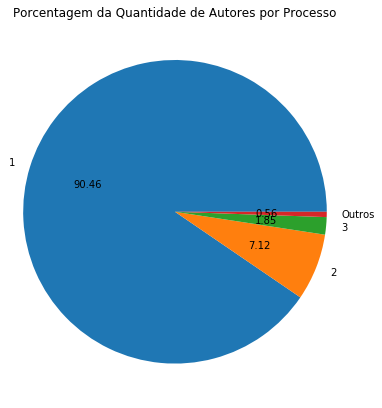

In [0]:
# Pie Chart da tendência de número de autores por processo 
plt.figure(figsize=(6,6))
plt.pie(df_num_autores['count'], labels=df_num_autores['num_autores'], autopct='%.2f')
plt.axis('equal')
fig = plt.gcf()
fig.subplots_adjust(top=1)
plt.title('Porcentagem da Quantidade de Autores por Processo')
plt.show()

Como apresentado acima, através do gráfico Pie Chart, pode-se observar que, dentre os autores registrados, tem-se que 90.46% dos processos possuem apenas uma pessoa ou entidade como autor; 7.12% tem dois autores associados; 1.85% para processos com três autores; e, por fim, 0.56% estão associados a quatro ou mais autores, sendo representado, para fins de visualização, pelo identificador "Outros".

Em seguida é apresentado o gráfico respectivo à contagem dos réus nos processos.

In [0]:
# Dicionário para o número de réus por processo
num_reus = {}

# Loop para contagem do número de réus em cada processo registrado
for line in processos['reu']:
  num = 0
  aux = line.split('\n')
  for item in aux:
    num += int(detectar_real(extrair_nome(item),'reu'))
    
  if num == 0:
    continue

  if num in num_reus:
    num_reus[num] += 1
  else:
    num_reus[num] = 1
    
# Transformando o dicionário em dataframe para manipulação posterior    
df_num_reus = pd.DataFrame()
df_num_reus['num_reus'] = num_reus.keys()
df_num_reus['count'] = num_reus.values()
df_num_reus = df_num_reus.sort_values(by=['num_reus'],ascending=True).reset_index(drop=True)

# Seleção dos principais resultados e concatenando os menores em "Outros" para uma melhor 
# visualização do Pie Chart
main_nums = df_num_reus[:1]
outros = pd.DataFrame([['Outros',df_num_reus[1:].sum(axis=0)[1]]], columns=['num_reus','count'])
df_num_reus = main_nums.append(outros, ignore_index=True)

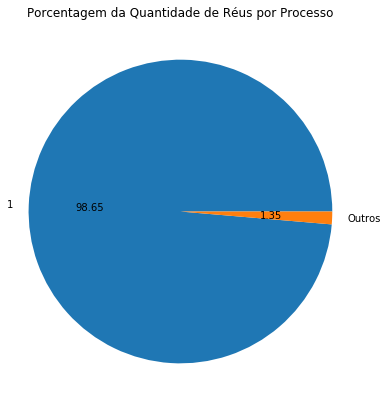

In [0]:
# Pie Chart da tendência de número de réus por processo 
plt.figure(figsize=(6,6))
plt.pie(df_num_reus['count'], labels=df_num_reus['num_reus'],autopct='%.2f')
plt.axis('equal')
fig = plt.gcf()
fig.subplots_adjust(top=1)
plt.title('Porcentagem da Quantidade de Réus por Processo')
plt.show()

O gráfico acima sinaliza que 98.65% dos processos estão associados a apenas um réu registrado; e 1.35% contém dois ou mais réus, sendo representado no gráfico através do identificador "Outros".

## Réus de maior frequência

Para este tópico, diferentemente da análise de réus apresentada anteriormente, foi realizada uma contagem individual de processos por réu, de modo que fosse possível isolar os cinco réus que apresentaram maior frequência. Os demais réus são contabilizados, no primeiro gráfico, em "Outros", para fins de uma melhor visuaização.

In [0]:
# Dicionário para armazenar a frequência dos réus
reus = {}

# Iteração pelos réus, com o objetivo de calcular a frequência 
for line in processos['reu']:
  num = 0
  aux = line.split('\n')
  for item in aux:
    item = extrair_nome(item)
    if detectar_real(item,'reu') == True:
      if item in reus:
        reus[item] += 1
      else:
        reus[item] = 1
    
# Transformando o dicionário em dataframe para manipulação posterior    
df_reus = pd.DataFrame()
df_reus['reus'] = reus.keys()
df_reus['count'] = reus.values()
df_reus = df_reus.sort_values(by=['count'],ascending=False).reset_index(drop=True)

# Seleção dos principais resultados e concatenando os menores em "Outros" 
reus_principais = df_reus[:5]
outros = pd.DataFrame([['OUTROS',df_reus[5:].sum(axis=0)[1]]], columns=['reus','count'])
df_reus_principais = reus_principais.append(outros, ignore_index=True)

In [0]:
# Gráfico com os réus de maior frequência dentre os processos
layout = {
    'width': 900,
    'height': 600,
    'xaxis': {
        'categoryorder': 'array',
        'categoryarray': [x for _, x in sorted(zip(df_reus_principais['count'], df_reus_principais['reus']))]
    },
    'title' : 'Réus de maior frequência dentre os processos registrados'
}

fig = go.FigureWidget(data = [go.Bar(x=df_reus_principais['reus'], y=df_reus_principais['count']
                                     ,marker={'color': df_reus_principais['count'],'colorscale': 'Viridis'})],
                      layout = layout)
fig.update_xaxes(tickangle=45)
fig.show()

Como apresentado acima, tem-se que o INSS apresenta um número de processos extremamente superior aos demais, com envolvimento em, aproximadamente, 290 mil. Em seguida, pode-se perceber a Caixa Econômica Federal, a União e a Fazenda Nacional. 

Contudo, antes de realizar uma análise aprofundada desses quatro réus referente aos assuntos dos respectivos processos no tópico seguinte, abaixo foi criado um histograma dos réus registrados em "Outros" no gráfico anterior, com o intuito de explorar visualmente esses dados.

Visto a natureza dos gráficos gerados pela ferramenta Plotly, é possível, em ambos os gráficos, utilizar o cursor para visualizar, de forma iterativa, o identificador e a respectiva quantidade em cada barra.

In [0]:
# Gráfico com os réus armazenados em "Outros"
layout = {
    'width': 900,
    'height': 600,
    'xaxis': {
        'categoryorder': 'array',
        'categoryarray': [x for _, x in sorted(zip(df_reus[5:]['count'], df_reus[5:]['reus']))]
    },
    'title' : 'Frequência dos réus armazenados em "Outros"'
}

fig = go.FigureWidget(data = [go.Bar(x=df_reus[5:]['reus'], y=df_reus[5:]['count']
                                     ,marker={'color': df_reus[5:]['count'],'colorscale': 'Viridis'})],
                      layout = layout)
fig.show()

## Assuntos dos processos relacionados aos quatro réus de maior frequência

Como citado anteriormente, este tópico é voltado aos assuntos dos processos pertinentes aos quatro principais réus.

O primeiro gráfico desenvolvido consiste na representação, em formato de rede, da ligação que os assuntos têm com os quatro réus, ou seja, a quantos estão ligados, o que torna possível observar as tendências dentre os assuntos e quais são mais prováveis de atingir essas diversas entidades. 

Os assuntos apresentam uma coloração de acordo com o número de ligações causadas pelos réus aos quais estão associados. Enquanto que os réus possuem colorações específicas: INSS é identificado pela cor lilás; Caixa Econômica Federal com a cor verde; União com a cor amarela; e a Fazenda Nacional com a cor rosa. Além disso, enquanto que a conectividade dos assuntos é dado em escala logarítmica, os réus apresentam o número concreto de suas conexões.

Dado a abordagem iterativa com o Plotly e Networkx, é possível iteragir com o gráfico para visualizar as identificações dos nós e seus respectivos graus de conectividade. Isso foi possível através do tutorial fornecido neste [link](https://medium.com/@anand0427/network-graph-with-at-t-data-using-plotly-a319f9898a02).

In [0]:
# Selecionando os quatro principais réus
reus_quatro_principais = df_reus[:4]

# Isolando os processos em específicos dataframes de acordo com os réus registrados
inss = processos.loc[processos['reu'].str.contains(reus_quatro_principais.loc[0,'reus'])]
caixa = processos.loc[processos['reu'].str.contains(reus_quatro_principais.loc[1,'reus'])]
uniao = processos.loc[processos['reu'].str.contains(reus_quatro_principais.loc[2,'reus'])]
fazenda = processos.loc[processos['reu'].str.contains(reus_quatro_principais.loc[3,'reus'])]
outros = processos.loc[processos['reu'].str.contains('|'.join([reus_quatro_principais.loc[0,'reus'],
                                                               reus_quatro_principais.loc[1,'reus'],
                                                               reus_quatro_principais.loc[2,'reus'],
                                                               reus_quatro_principais.loc[3,'reus']]))]

In [0]:
# Armazenando as quantidades dos processos pelos quatro réus principais e os demais em 'Outros'
distribuicao_processos = pd.DataFrame(columns=['reu','count'])
distribuicao_processos.loc[0] = ['INSS', inss.shape[0]]
distribuicao_processos.loc[1] = ['CAIXA ECONOMICA FEDERAL', caixa.shape[0]]
distribuicao_processos.loc[2] = ['UNIAO', uniao.shape[0]]
distribuicao_processos.loc[3] = ['FAZENDA NACIONAL', fazenda.shape[0]]
distribuicao_processos.loc[4] = ['OUTROS', outros.shape[0]]

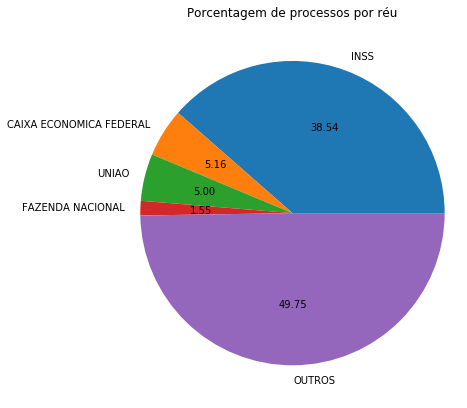

In [0]:
# Pie Chart da tendência de número de réus por processo 
plt.figure(figsize=(6,6))
plt.pie(distribuicao_processos['count'], labels=distribuicao_processos['reu'],autopct='%.2f')
plt.axis('equal')
fig = plt.gcf()
fig.subplots_adjust(top=1)
plt.title('Porcentagem de processos por réu')
plt.show()

In [0]:
# Acessando os assuntos registrados nos processos selecionados anteriormente
colunas = ['num_processo','reu','detalhe_assunto']

inss = inss.merge(assuntos, on='num_processo', how='inner')[colunas]
caixa = caixa.merge(assuntos, on='num_processo', how='inner')[colunas]
uniao = uniao.merge(assuntos, on='num_processo', how='inner')[colunas]
fazenda = fazenda.merge(assuntos, on='num_processo', how='inner')[colunas]

In [0]:
# Organizando os dados de modo que na primeira coluna esteja os assuntos e na segunda o réu respectivo do processo.
inss_nodes = pd.DataFrame()
inss_nodes['node1'] = inss['detalhe_assunto']
inss_nodes['node2'] = 'INSS'

caixa_nodes = pd.DataFrame()
caixa_nodes['node1'] = caixa['detalhe_assunto']
caixa_nodes['node2'] = 'CAIXA ECONOMICA FEDERAL'

uniao_nodes = pd.DataFrame()
uniao_nodes['node1'] = uniao['detalhe_assunto']
uniao_nodes['node2'] = 'UNIAO'

fazenda_nodes = pd.DataFrame()
fazenda_nodes['node1'] = fazenda['detalhe_assunto']
fazenda_nodes['node2'] = 'FAZENDA NACIONAL'

In [0]:
# Construção do gráfico representativo das ligações entre os assuntos e os réus 

# Concatenando os quatro dataframes em um representativo das conexões gerais
dfs = [inss_nodes,caixa_nodes,uniao_nodes,fazenda_nodes]
node_connections = pd.concat(dfs)

# Cada assunto e réu será tratado como um nó no gráfico
node1 = list(node_connections['node1'].unique())
node2 = list(node_connections['node2'].unique())
node_list = list(set(node1+node2))

# Criação de um gráfico networkx
G = nx.Graph()

# Inserindo os nós no gráfico
for i in node_list:
    G.add_node(i)

# Criando as conexões entre os nós
for i,j in node_connections.iterrows():
    G.add_edges_from([(j['node1'],j["node2"])])

# Posições dos nós no gráfico
pos = nx.kamada_kawai_layout(G)
for n, p in pos.items():
    G.nodes[n]['pos'] = p

edge_trace = go.Scatter(
    x=[],
    y=[],
    line=dict(width=0.5,color='#888'),
    hoverinfo='none',
    mode='lines')

for edge in G.edges():
    x0, y0 = G.nodes[edge[0]]['pos']
    x1, y1 = G.nodes[edge[1]]['pos']
    edge_trace['x'] += tuple([x0, x1, None])
    edge_trace['y'] += tuple([y0, y1, None])

node_trace = go.Scatter(
    x=[],
    y=[],
    text=[],
    mode='markers',
    hoverinfo='text',
    marker=dict(
        showscale=True,
        colorscale = 'RdBu',
        reversescale=True,
        color=[],
        size=[],
        colorbar=dict(
            thickness=15,
            title='Conectividade dos assuntos, em escala logarítmica',
            xanchor='left',
            titleside='right'
        ),
        line=dict(width=0)))

for node in G.nodes():
    x, y = G.nodes[node]['pos']
    node_trace['x'] += tuple([x])
    node_trace['y'] += tuple([y])

# Mapeando os nós com seus respectivos identificadores e o número de conexões que possui dentre os presentes
aux = 0
color_list = ['rgb(187, 166, 247)','rgb(166, 247, 190)','rgb(244, 247, 166)','rgb(247, 166, 243)']
for node, adjacencies in enumerate(G.adjacency()):
  if adjacencies[0] in ['INSS','UNIAO','CAIXA ECONOMICA FEDERAL','FAZENDA NACIONAL']:
    node_trace['marker']['size'] += tuple([20])
    node_trace['marker']['color'] += tuple([color_list[aux]])
    aux += 1
    node_info = adjacencies[0] +' # de assuntos conectados: '+str(len(adjacencies[1]))
    node_trace['text']+=tuple([node_info])
  else:
    node_trace['marker']['size'] += tuple([12])
    node_trace['marker']['color']+=tuple(np.log([node_connections[node_connections['node1'] == adjacencies[0]].shape[0]]))
    node_info = adjacencies[0] +' # log de conexões com os réus: '+str(np.log(node_connections[node_connections['node1'] == adjacencies[0]].shape[0]))
    node_trace['text']+=tuple([node_info])

# Gráfico
fig = go.Figure(data=[edge_trace, node_trace],
             layout=go.Layout(
                title='<br>Conexão dos assuntos com os quatro principais réus',
                titlefont=dict(size=16),
                showlegend=False,
                hovermode='closest',
                margin=dict(b=20,l=5,r=5,t=40),
                annotations=[ dict(
                    showarrow=False,
                    text='',
                    xref="paper", yref="paper") ],
                xaxis=dict(showgrid=False, zeroline=False, showticklabels=False),
                yaxis=dict(showgrid=False, zeroline=False, showticklabels=False)))
fig.show()

Além disso, também foram desenvolvidos gráficos para visualização dos dez assuntos de maior frequência, para cada um dos quatro réus, como apresentado abaixo.

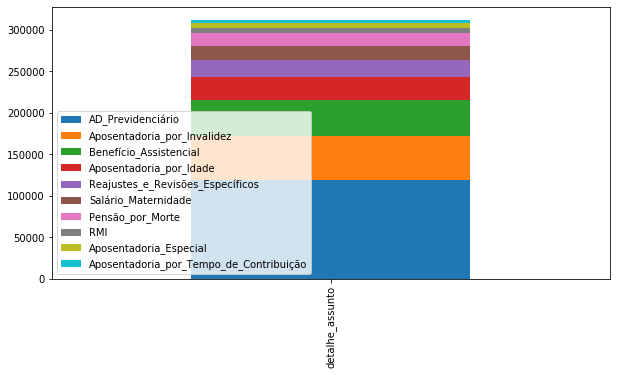

In [0]:
# Os dez assuntos de maior frequência dentre os processos que possuem o INSS como réu
inss_principais = inss['detalhe_assunto'].value_counts().rename_axis('assuntos').reset_index(name='counts')[:10].assuntos.tolist()
inss_toplot = inss.loc[inss['detalhe_assunto'].isin(inss_principais)]
inss_toplot['detalhe_assunto'].value_counts().to_frame().T.plot(kind='bar',stacked=True,figsize=(10,5))

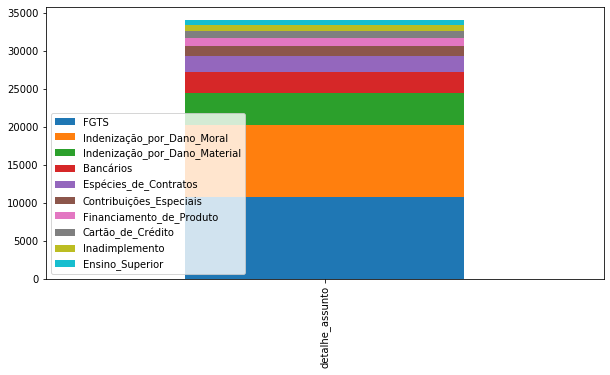

In [0]:
# Os dez assuntos de maior frequência dentre os processos que possuem a Caixa Econômica Federal como réu
caixa_principais = caixa['detalhe_assunto'].value_counts().rename_axis('assuntos').reset_index(name='counts')[:10].assuntos.tolist()
caixa_toplot = caixa.loc[caixa['detalhe_assunto'].isin(caixa_principais)]
caixa_toplot['detalhe_assunto'].value_counts().to_frame().T.plot(kind='bar',stacked=True,figsize=(10,5))

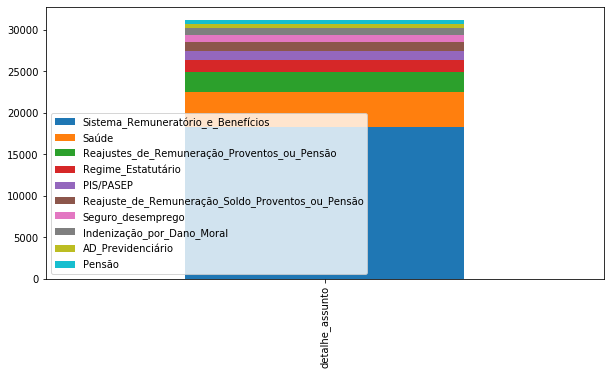

In [0]:
# Os dez assuntos de maior frequência dentre os processos que possuem a União como réu
uniao_principais = uniao['detalhe_assunto'].value_counts().rename_axis('assuntos').reset_index(name='counts')[:10].assuntos.tolist()
uniao_toplot = uniao.loc[uniao['detalhe_assunto'].isin(uniao_principais)]
uniao_toplot['detalhe_assunto'].value_counts().to_frame().T.plot(kind='bar',stacked=True,figsize=(10,5))

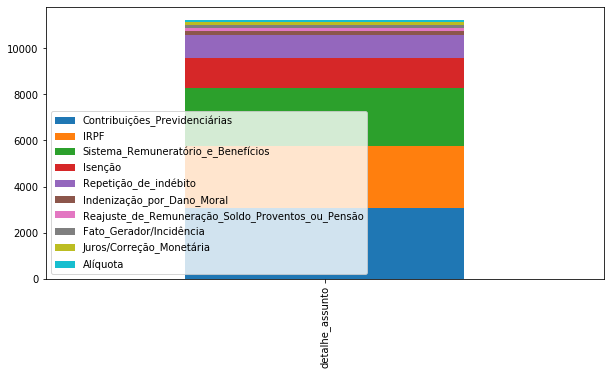

In [0]:
# Os dez assuntos de maior frequência dentre os processos que possuem a Fazenda Nacional como réu
fazenda_principais = fazenda['detalhe_assunto'].value_counts().rename_axis('assuntos').reset_index(name='counts')[:10].assuntos.tolist()
fazenda_toplot = fazenda.loc[fazenda['detalhe_assunto'].isin(fazenda_principais)]
fazenda_toplot['detalhe_assunto'].value_counts().to_frame().T.plot(kind='bar',stacked=True,figsize=(10,5))

## Conectividade entre os réus dos processos

Visto que muitos processos possuem mais um réu registrado, este tópico é voltado para o desenvolvimento de um gráfico de rede representativo das conexões entre os réus. Devido à característica dinâmica do gráfico, é possível isolar diferentes segmentos para uma visualização mais específica, assim como acessar a identificação e a conectividade dos nós, esta representada em escala logarítmica. 

In [0]:
# Dicionário para armazenar a frequência dos réus
reus = {}

# Lista para armazenar as associações entre os réus
associacoes = []

for line in processos['reu']:
  num = 0
  list_aux = []
  aux = line.split('\n')
  for item in aux:
    item = extrair_nome(item)
    if detectar_real(item,'reu') == True:
      list_aux.append(item)
  if(len(list_aux) > 1):
    combinacoes(list_aux,associacoes)


# Transformando as associações em dataframe para serem tratadas como ligações entre nós
associacoes = pd.DataFrame(associacoes,columns=['node1','node2'])

In [0]:
# Gráfico das ligações entre os réus 

# Cada réu será tratado como um nó no gráfico
node1 = list(associacoes['node1'].unique())
node2 = list(associacoes['node2'].unique())
node_list = list(set(node1+node2))

# Criação de um gráfico networkx
G = nx.Graph()

# Inserindo os nós no gráfico
for i in node_list:
    G.add_node(i)

# Criando as conexões entre os nós
for i,j in associacoes.iterrows():
    G.add_edges_from([(j['node1'],j['node2'])])

# Posições dos nós no gráfico
pos = nx.spring_layout(G, k=0.5, iterations=50)
for n, p in pos.items():
    G.nodes[n]['pos'] = p

edge_trace = go.Scatter(
    x=[],
    y=[],
    line=dict(width=0.5,color='#888'),
    hoverinfo='none',
    mode='lines')

for edge in G.edges():
    x0, y0 = G.nodes[edge[0]]['pos']
    x1, y1 = G.nodes[edge[1]]['pos']
    edge_trace['x'] += tuple([x0, x1, None])
    edge_trace['y'] += tuple([y0, y1, None])

node_trace = go.Scatter(
    x=[],
    y=[],
    text=[],
    mode='markers',
    hoverinfo='text',
    marker=dict(
        showscale=True,
        colorscale = 'RdBu',
        reversescale=True,
        color=[],
        size=10,
        colorbar=dict(
            thickness=15,
            title='Conectividade dos réus, em escala logarítmica',
            xanchor='left',
            titleside='right'
        ),
        line=dict(width=0)))

for node in G.nodes():
    x, y = G.nodes[node]['pos']
    node_trace['x'] += tuple([x])
    node_trace['y'] += tuple([y])

# Mapeando os nós com seus respectivos réus e o número de conexões que possui
for node, adjacencies in enumerate(G.adjacency()):
    node_trace['marker']['color']+=tuple([np.log(len(adjacencies[1]))])
    node_info = adjacencies[0] +' # log de conexões: '+str(np.log(len(adjacencies[1])))
    node_trace['text']+=tuple([node_info])

# Gráfico
fig = go.Figure(data=[edge_trace, node_trace],
             layout=go.Layout(
                title='Conexão entre os réus',
                titlefont=dict(size=16),
                showlegend=False,
                hovermode='closest',
                margin=dict(b=20,l=5,r=5,t=40),
                annotations=[ dict(
                    showarrow=False,
                    text='',
                    xref="paper", yref="paper") ],
                xaxis=dict(showgrid=False, zeroline=False, showticklabels=False),
                yaxis=dict(showgrid=False, zeroline=False, showticklabels=False)))
fig.show()

Como apresentado acima, tem-se que dentre os réus visualizados, tem-se em destaque a Caixa Econômica Federal, a União, o Estado do Rio Grande do Norte, o INSS e a Fazenda Nacional, como as entidades que, dentre seus respectivos processos, estabeleceram conexões com um número maior de diversos outros réus.

## Word Cloud de assuntos dos processos

Com o intuito de visualizar quais assuntos, dentre todos os processos, apresentam maior frequência, foi construído um Word Cloud. Dado o número alto de dados a serem considerados, para efeito de melhor visualização, foi selecionado 70% dos assuntos para a criação da imagem.

In [0]:
# Selecionar, aleatoriamente, um conjunto de palavras para representar no Word Cloud 
selec_linhas = assuntos['detalhe_assunto'].sample(frac=0.7,random_state=1)

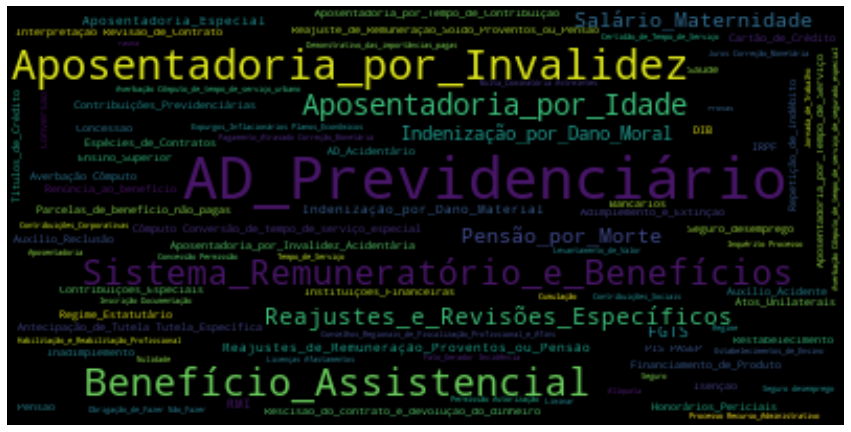

In [0]:
# Imagem Word Cloud
wordcloud = WordCloud().generate(" ".join(selec_linhas))

# Exibição da imagem gerada
plt.figure(figsize=(15,20))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

Dado o resultado apresentado, é possível verificar que "Auxílio-Doença Previdenciário", "Aposentadoria por invalidez", "Sistema Remuneratório e benefícios", "Benefício Assistencial" e "Aposentadoria por idade" encontram-se como os de maior representatividade.

## Análise comparativa entre processos, com base na prioridade processual

Dado a possibilidade de registrar um processo como sendo de prioridade processual, foi decidido analisar a proporção de processos registrados ou não com prioridade processual. As variáveis comparativas são os assuntos que apresentaram maior frequência nos processos de prioridade.

In [0]:
# Processos com prioridade processual
com_prioridade = processos[processos['prioridade_processual'] == 'S'].reset_index(drop=True)

# Processos sem prioridade processual
sem_prioridade = processos[processos['prioridade_processual'] == 'N'].reset_index(drop=True)

In [0]:
# Selecionar os assuntos de maior frequência em processos com prioridade processual
colunas = ['num_processo','data_ajuizamento','autor','reu','assunto','complemento_assunto','detalhe_assunto']
# Associar os processos com prioridade processual aos seus respectivos assuntos
com_prioridade = com_prioridade.merge(assuntos,on='num_processo', how='inner')[colunas]

# Associar os processos sem prioridade processual aos seus respectivos assuntos
sem_prioridade = sem_prioridade.merge(assuntos,on='num_processo', how='inner')[colunas]

# Contagem de cada assunto dentre os processos registrados e seleção dos dez principais
aux = com_prioridade['detalhe_assunto'].value_counts()
count_prioridade = pd.DataFrame({'detalhe_assunto':aux.index,'count_com':aux.values})
count_prioridade_10 = count_prioridade[:10]

In [0]:
# Selecionando os processos que tenham um dos dez principais assuntos
com_prioridade_10 = com_prioridade.loc[com_prioridade['detalhe_assunto'].isin(count_prioridade_10['detalhe_assunto']
                                                                           .tolist())]
sem_prioridade_10 = sem_prioridade.loc[sem_prioridade['detalhe_assunto'].isin(count_prioridade_10['detalhe_assunto']
                                                                           .tolist())]                                                                           

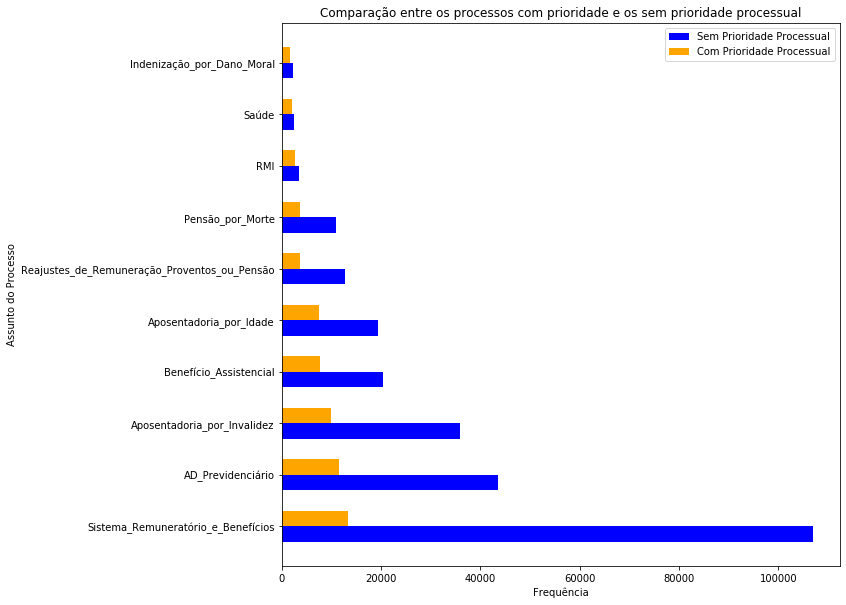

In [0]:
# Gráfico de comparação entre a frequência de processos com prioridade e os sem prioridade processual,
# dado um conjunto dos assuntos de maior frequência dentre os processos com prioridade 
fig, ax = plt.subplots(figsize=(10,10))

bar_width = 0.3
index = np.arange(10)

sem_prd = ax.barh(index, sem_prioridade_10['detalhe_assunto'].value_counts(), bar_width,
                  label='Sem Prioridade Processual',color='blue')

com_prd = ax.barh(index+bar_width, com_prioridade_10['detalhe_assunto'].value_counts(), bar_width,
                label='Com Prioridade Processual', color='orange')

ax.set_xlabel('Frequência')
ax.set_ylabel('Assunto do Processo')
ax.set_title('Comparação entre os processos com prioridade e os sem prioridade processual')
ax.set_yticks(index + bar_width / 2)
ax.set_yticklabels([i.split('(')[0] for i in count_prioridade_10['detalhe_assunto']])
ax.legend()

plt.show()

O resultado apresentado pelo gráfico acima é intrigante visto os assuntos apresentados, os quais, devido às situações que abordam, era esperado que o número de processos de prioridade ultrapassasse os sem prioridade.

Complementarmente, tem-se, também, uma análise comparativa com base nos assuntos em que a quantidade de processos de prioridade ultrapassaram os que não possuiam, com o objetivo de observar quais são.

In [0]:
# Contagem de cada assunto dentre os processos registrados sem prioridade
aux = sem_prioridade['detalhe_assunto'].value_counts()
count_sem_prioridade = pd.DataFrame({'detalhe_assunto':aux.index,'count_sem':aux.values})

# Merge entre o dataframe de frequência dos assuntos para processos com prioridade 
# e o dataframe de frequência dos assuntos para processos sem prioridade
colunas = ['detalhe_assunto','count_com','count_sem']
merge = count_prioridade.merge(count_sem_prioridade, on='detalhe_assunto', how='inner')[colunas]

# Selecionando os assuntos em que o número de processos com prioridade é superior aos sem prioridade processual
count_prioridade_superior = merge[merge['count_com'] > merge['count_sem']][:5]

In [0]:
# Selecionando os processos que tenham um dos dez principais assuntos
com_prioridade_superior = com_prioridade.loc[com_prioridade['detalhe_assunto']
                                             .isin(count_prioridade_superior['detalhe_assunto'].tolist())]
sem_prioridade_inferior = sem_prioridade.loc[sem_prioridade['detalhe_assunto']
                                             .isin(count_prioridade_superior['detalhe_assunto'].tolist())]    

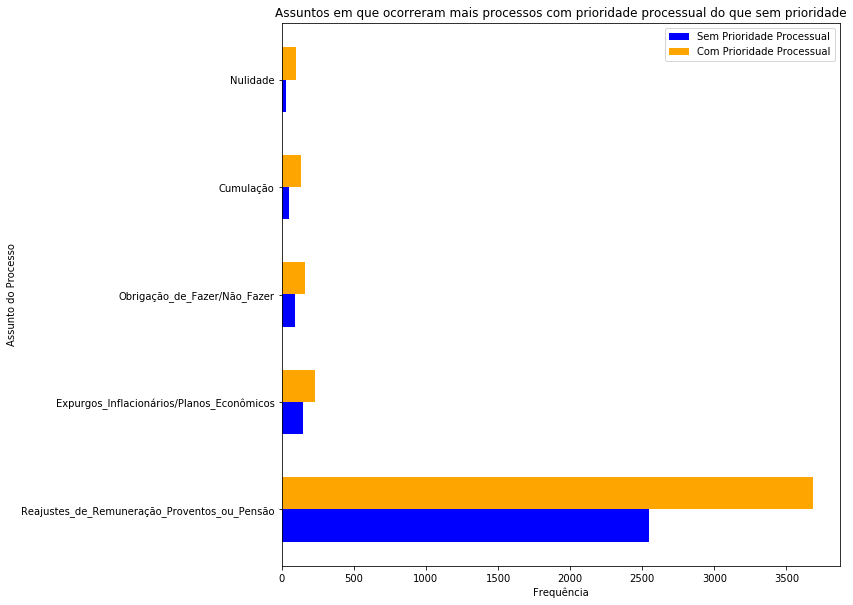

In [0]:
# Gráfico de comparação entre a frequência de processos com prioridade e os sem prioridade processual,
# dado um conjunto dos assuntos em que os processos com prioridade excedem a quantidade dos sem prioridade
fig, ax = plt.subplots(figsize=(10,10))

bar_width = 0.3
index = np.arange(5)

sem_prd = ax.barh(index, sem_prioridade_inferior['detalhe_assunto'].value_counts(), bar_width,
                label='Sem Prioridade Processual', color='blue')

com_prd = ax.barh(index+bar_width, com_prioridade_superior['detalhe_assunto'].value_counts(), bar_width,
                label="Com Prioridade Processual", color='orange')

ax.set_xlabel('Frequência')
ax.set_ylabel('Assunto do Processo')
ax.set_title('Assuntos em que ocorreram mais processos com prioridade processual do que sem prioridade')
ax.set_yticks(index + bar_width / 2)
ax.set_yticklabels([i.split('(')[0] for i in count_prioridade_superior['detalhe_assunto']])
ax.legend()

plt.show()

Logo, tem-se que, com base nos dados registrados, os assuntos "Reajustes de Remuneração, Proventos ou Pensão", "Expurgos Inflacionários/Planos Econômicos", "Obrigação de Fazer/Não Fazer", "Cumulação" e "Nulidade", apresentam efetivamente um número maior dentre os processos com prioridade processual. 

## Conectividade entre os temas apresentados por processos que possuem múltiplos assuntos registrados 

Seguindo a abordagem de gráfico de redes apresentado no tópico "Assuntos dos processos relacionados aos quatro réus de maior frequência", este tópico em questão é voltado para a conexão entre os temas provenientes de processos que possuem múltiplos assuntos registrados. Dado a capacidade iterativa do gráfico, é possível acessar, com o cursor, a identificação e a conectividade dos nós, esta representada em escala logarítmica.

In [0]:
# Selecionando as linhas respectivas à ocasião em que um processo tem mais de um assunto registrado
num_duplicado = assuntos[assuntos['num_processo'].duplicated(keep=False)][['detalhe_assunto','num_processo']]

# Agrupando as linhas  pelo número do processo
group_duplicado = num_duplicado.groupby(by='num_processo')

# Lista para armazenar as associações entre os assuntos
associacoes = []

for num in group_duplicado.groups.keys():
  combinacoes(group_duplicado.get_group(num)['detalhe_assunto'].tolist(), associacoes)

# Transformando as associações em dataframe para serem tratadas como ligações entre nós
associacoes = pd.DataFrame(associacoes,columns=['node1','node2']) 

In [0]:
# Gráfico das ligações entre os assuntos 

# Cada assunto será tratado como um nó no gráfico
node1 = list(associacoes['node1'].unique())
node2 = list(associacoes['node2'].unique())
node_list = list(set(node1+node2))

# Criação de um gráfico networkx
G = nx.Graph()

# Inserindo os nós no gráfico
for i in node_list:
    G.add_node(i)

# Criando as conexões entre os nós
for i,j in associacoes.iterrows():
    G.add_edges_from([(j['node1'],j["node2"])])

# Posições dos nós no gráfico
pos = nx.spring_layout(G, k=0.5, iterations=50)
for n, p in pos.items():
    G.nodes[n]['pos'] = p

edge_trace = go.Scatter(
    x=[],
    y=[],
    line=dict(width=0.5,color='#888'),
    hoverinfo='none',
    mode='lines')

for edge in G.edges():
    x0, y0 = G.nodes[edge[0]]['pos']
    x1, y1 = G.nodes[edge[1]]['pos']
    edge_trace['x'] += tuple([x0, x1, None])
    edge_trace['y'] += tuple([y0, y1, None])

node_trace = go.Scatter(
    x=[],
    y=[],
    text=[],
    mode='markers',
    hoverinfo='text',
    marker=dict(
        showscale=True,
        colorscale = 'RdBu',
        reversescale=True,
        color=[],
        size=15,
        colorbar=dict(
            thickness=15,
            title='Conectividade dos assuntos, em escala logarítmica',
            xanchor='left',
            titleside='right'
        ),
        line=dict(width=0)))

for node in G.nodes():
    x, y = G.nodes[node]['pos']
    node_trace['x'] += tuple([x])
    node_trace['y'] += tuple([y])

# Mapeando os nós com seus respectivos identificadores do assunto e o número de conexões que possui
for node, adjacencies in enumerate(G.adjacency()):
    node_trace['marker']['color']+=tuple([np.log(len(adjacencies[1]))])
    node_info = adjacencies[0] +' # de conexões: '+str(np.log(len(adjacencies[1])))
    node_trace['text']+=tuple([node_info])

# Gráfico
fig = go.Figure(data=[edge_trace, node_trace],
             layout=go.Layout(
                title='Conexão entre os assuntos',
                titlefont=dict(size=16),
                showlegend=False,
                hovermode='closest',
                margin=dict(b=20,l=5,r=5,t=40),
                annotations=[ dict(
                    showarrow=False,
                    text='',
                    xref="paper", yref="paper") ],
                xaxis=dict(showgrid=False, zeroline=False, showticklabels=False),
                yaxis=dict(showgrid=False, zeroline=False, showticklabels=False)))
fig.show()

É possível verificar que os assuntos "Indenização por Dano Moral", "Indenização por Dano Material" e "Sistema Remunetário e Benefícios", apresentam um alto grau de associação com os demais. 

## Conectividade de assuntos e réus com o tópico "Indenização por Dano Moral"

Com base na ênfase em "Indenização por Dano Moral" exposta no gráfico anterior, foi decidido explorar a conectividade que esse assunto possui especificamente, tanto com outros assuntos quanto com os réus associados aos seus respectivos processos. 

Foram produzidos dois outros gráficos de rede, ambos os quais possuem o nó "Indenização por Dano Moral" sinalizado pela cor lilás. Enquanto isso, todos os demais nós possuem uma coloração específica, dentre a escala logarítmica, ao grau de conexão exibido.

In [0]:
# Merge entre o dataframe dos processos com prioridade e o dataframe dos assuntos
colunas = ['num_processo','autor','reu','detalhe_assunto']
aux = processos.merge(assuntos,on='num_processo', how='inner')[colunas]

# Seleção dos processos que possuem "Indenização por Dano Moral" registrado como assunto
com_indenizacao_moral = aux[aux['detalhe_assunto'] == 'Indenização_por_Dano_Moral']

In [0]:
# Lista para armazenar os réus
list_reus = []

# Iteração entre os réus que possuem "Indenização por Dano Moral" registrado como assunto
for line in com_indenizacao_moral['reu']:
  num = 0
  aux = line.split('\n')
  for item in aux:
    item = extrair_nome(item)
    if detectar_real(item,'reu') == True:
      list_reus.append(item)

# Transformando as associações em dataframe para serem tratadas como ligações entre nós
associacoes = pd.DataFrame()
associacoes['node1'] = pd.Series(list_reus)
associacoes['node2'] = 'Indenização_por_Dano_Moral'

In [0]:
# Cada réu será tratado como um nó no gráfico
node1 = list(associacoes['node1'].unique())
node2 = list(associacoes['node2'].unique())
node_list = list(set(node1+node2))

# Criação de um gráfico networkx
G = nx.Graph()

# Inserindo os nós no gráfico
for i in node_list:
    G.add_node(i)

# Criando as conexões entre os nós
for i,j in associacoes.iterrows():
    G.add_edges_from([(j['node1'],j["node2"])])

# Posições dos nós no gráfico
pos = nx.kamada_kawai_layout(G)
for n, p in pos.items():
    G.nodes[n]['pos'] = p

edge_trace = go.Scatter(
    x=[],
    y=[],
    line=dict(width=0.5,color='#888'),
    hoverinfo='none',
    mode='lines')

for edge in G.edges():
    x0, y0 = G.nodes[edge[0]]['pos']
    x1, y1 = G.nodes[edge[1]]['pos']
    edge_trace['x'] += tuple([x0, x1, None])
    edge_trace['y'] += tuple([y0, y1, None])

node_trace = go.Scatter(
    x=[],
    y=[],
    text=[],
    mode='markers',
    hoverinfo='text',
    marker=dict(
        showscale=True,
        colorscale = 'RdBu',
        reversescale=True,
        color=[],
        size=[],
        colorbar=dict(
            thickness=15,
            title='Conectividade dos réus, em escala logarítmica',
            xanchor='left',
            titleside='right'
        ),
        line=dict(width=0)))

for node in G.nodes():
    x, y = G.nodes[node]['pos']
    node_trace['x'] += tuple([x])
    node_trace['y'] += tuple([y])

# Mapeando os nós com seus respectivos identificadores e o número de conexões que possui dentre os presentes
for node, adjacencies in enumerate(G.adjacency()):
  if adjacencies[0] == 'Indenização_por_Dano_Moral':
    node_trace['marker']['size'] += tuple([20])
    node_trace['marker']['color'] += tuple(['rgb(187, 166, 247)'])
    node_info = adjacencies[0] +' # de conexões: '+str(len(adjacencies[1]))
    node_trace['text']+=tuple([node_info])
  else:
    node_trace['marker']['size'] += tuple([12])
    node_trace['marker']['color']+=tuple([np.log(associacoes[associacoes['node1'] == adjacencies[0]].shape[0])])
    node_info = adjacencies[0] +' # log de conexões com o réu: '+str(np.log(associacoes[associacoes['node1'] == adjacencies[0]].shape[0]))
    node_trace['text']+=tuple([node_info])

# Gráfico
fig = go.Figure(data=[edge_trace, node_trace],
             layout=go.Layout(
                title="<br>Conexão do assunto 'Indenização por Dano Moral' com os réus",
                titlefont=dict(size=16),
                showlegend=False,
                hovermode='closest',
                margin=dict(b=20,l=5,r=5,t=40),
                annotations=[ dict(
                    showarrow=False,
                    text='',
                    xref="paper", yref="paper") ],
                xaxis=dict(showgrid=False, zeroline=False, showticklabels=False),
                yaxis=dict(showgrid=False, zeroline=False, showticklabels=False)))
fig.show()

In [0]:
# Seleção dos assuntos associados à "Indenização por Dano Moral"
aux = assuntos[assuntos['detalhe_assunto'] != 'Indenização_por_Dano_Moral']
aux = aux[aux['num_processo'].isin(com_indenizacao_moral['num_processo'].tolist())]
associacoes = pd.DataFrame()
associacoes['node1'] = aux['detalhe_assunto']
associacoes['node2'] = 'Indenização_por_Dano_Moral'

In [0]:
# Cada assunto será tratado como um nó no gráfico
node1 = list(associacoes['node1'].unique())
node2 = list(associacoes['node2'].unique())
node_list = list(set(node1+node2))

# Criação de um gráfico networkx
G = nx.Graph()

# Inserindo os nós no gráfico
for i in node_list:
    G.add_node(i)

# Criando as conexões entre os nós
for i,j in associacoes.iterrows():
    G.add_edges_from([(j['node1'],j['node2'])])

# Posições dos nós no gráfico
pos = nx.kamada_kawai_layout(G)
for n, p in pos.items():
    G.nodes[n]['pos'] = p

edge_trace = go.Scatter(
    x=[],
    y=[],
    line=dict(width=0.5,color='#888'),
    hoverinfo='none',
    mode='lines')

for edge in G.edges():
    x0, y0 = G.nodes[edge[0]]['pos']
    x1, y1 = G.nodes[edge[1]]['pos']
    edge_trace['x'] += tuple([x0, x1, None])
    edge_trace['y'] += tuple([y0, y1, None])

node_trace = go.Scatter(
    x=[],
    y=[],
    text=[],
    mode='markers',
    hoverinfo='text',
    marker=dict(
        showscale=True,
        colorscale = 'RdBu',
        reversescale=True,
        color=[],
        size=[],
        colorbar=dict(
            thickness=15,
            title='Conectividade dos assuntos, em escala logarítmica',
            xanchor='left',
            titleside='right'
        ),
        line=dict(width=0)))

for node in G.nodes():
    x, y = G.nodes[node]['pos']
    node_trace['x'] += tuple([x])
    node_trace['y'] += tuple([y])

# Mapeando os nós com seus respectivos identificadores e o número de conexões que possui dentre os presentes
for node, adjacencies in enumerate(G.adjacency()):
  if adjacencies[0] == 'Indenização_por_Dano_Moral':
    node_trace['marker']['size'] += tuple([20])
    node_trace['marker']['color'] += tuple(['rgb(187, 166, 247)'])
    node_info = adjacencies[0] +' # de conexões: '+str(len(adjacencies[1]))
    node_trace['text']+=tuple([node_info])
  else:
    node_trace['marker']['size'] += tuple([12])
    node_trace['marker']['color']+=tuple([np.log(associacoes[associacoes['node1'] == adjacencies[0]].shape[0])])
    node_info = adjacencies[0] +' # log de conexões com o assunto: '+str(np.log(associacoes[associacoes['node1'] == adjacencies[0]].shape[0]))
    node_trace['text']+=tuple([node_info])


# Gráfico
fig = go.Figure(data=[edge_trace, node_trace],
             layout=go.Layout(
                title='<br>Conexão dos demais assuntos com "Indenização por Dano Moral"',
                titlefont=dict(size=16),
                showlegend=False,
                hovermode='closest',
                margin=dict(b=20,l=5,r=5,t=40),
                annotations=[ dict(
                    showarrow=False,
                    text='',
                    xref="paper", yref="paper") ],
                xaxis=dict(showgrid=False, zeroline=False, showticklabels=False),
                yaxis=dict(showgrid=False, zeroline=False, showticklabels=False)))
fig.show()

## Variação na quantidade de processos por mês, em cada ano

Esta seção é voltada para a construção de um gráfico de linhas, o qual é responsável por representar a variação na quantidade de processos por mês, em cada ano, para, com isso, ser possível identificar os picos e possíveis fatores responsáveis por causá-los.

In [0]:
# Seleção das datas de distribuição dos processos
inicio_processo = movimentacoes[movimentacoes['movimentacao'].str.lower().str.contains('conhecimento') & 
                                (movimentacoes['movimentacao'].str.lower().str.contains('análise inicial'))]
inicio_processo.reset_index(drop=True, inplace=True)

inicio_processo = inicio_processo.rename(columns={'data_movimentacao':'data_distribuicao'})

inicio_processo = inicio_processo.sort_values(by='data_distribuicao',ascending=True)
inicio_processo = inicio_processo[~inicio_processo['num_processo'].duplicated()]
inicio_processo.reset_index(drop=True, inplace=True)

# Acesso aos meses e anos das datas
inicio_processo['ano'] = inicio_processo['data_distribuicao'].dt.year
inicio_processo['mes'] = inicio_processo['data_distribuicao'].dt.month

In [0]:
# Agrupamento dos dados de acordo com o ano e o mês
aux = inicio_processo[['ano','mes']]
data_groups = aux.groupby(['ano','mes']).size().reset_index(name='count')

In [0]:
# Gráfico de linhas da variação na quantidade de processos por mês, em cada ano
fig = px.line(data_groups[~(data_groups['ano'] == 2019)], x='mes', y='count', color='ano')
fig.update_layout(title='Quantidade de processos por mês, em cada ano',
                   xaxis_title='Mês',
                   yaxis_title='Número de processos',
                   xaxis = dict(
                       tickmode = 'array',
                       tickvals = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12],
                       ticktext = ['Janeiro','Fevereiro','Março','Abril','Maio',
                                   'Junho','Julho','Agosto','Setembro','Outubro',
                                   'Novembro','Dezembro']
                       )
                   )
fig.show()

## Período entre a data de distribuição e a data de sentença dos processos

Este tópico é voltado para visualizar a frequência do número de dias provenientes dos períodos entre a data de distribuição e a data de sentença dos processos.

In [0]:
# Seleção das datas de sentença dos processos
sentenca_processo = movimentacoes[movimentacoes['movimentacao'].str.lower().str.contains('para sentença') &
                                  movimentacoes['movimentacao'].str.lower().str.contains('juiz')]
sentenca_processo.reset_index(drop=True, inplace=True)

sentenca_processo = sentenca_processo.rename(columns={'data_movimentacao':'data_sentenca'})

sentenca_processo = sentenca_processo.sort_values(by='data_sentenca',ascending=True)
sentenca_processo = sentenca_processo[~sentenca_processo['num_processo'].duplicated()]
sentenca_processo.reset_index(drop=True, inplace=True)

In [0]:
# Merge entre 'inicio_processo' e 'sentenca_processo'
colunas = ['num_processo','data_distribuicao','data_sentenca']
com_sentenca = inicio_processo.merge(sentenca_processo,on='num_processo', how='inner')[colunas]
com_sentenca = com_sentenca[~(com_sentenca['data_distribuicao']>com_sentenca['data_sentenca'])]
com_sentenca.reset_index(drop=True, inplace=True)

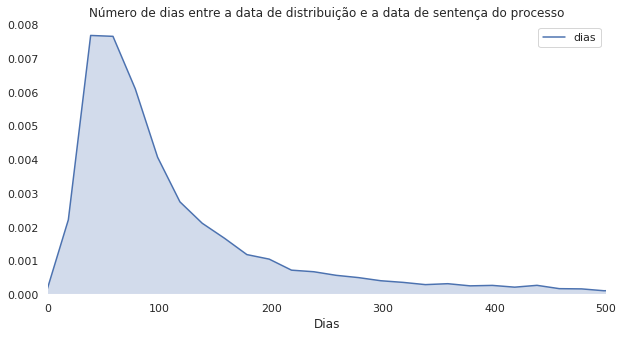

In [0]:
# Subtrair a data de ajuizamento da data de sentença para pegar os dias
julgamento = pd.DataFrame()
julgamento['dias'] = [(i-j).days for i,j in zip(com_sentenca['data_sentenca'],com_sentenca['data_distribuicao'])]

# Gráfico com a distribuição dos dias entre a data de ajuizamento e a data de sentença
sns.set(rc={'figure.figsize':(10,5)})
sns.set_context("notebook")
sns.set_style("white")
sns.kdeplot(julgamento['dias'], shade=True)
plt.xlabel("Dias")
plt.xlim(0,500)
sns.despine(bottom=True, left=True)
plt.title('Número de dias entre a data de distribuição e a data de sentença do processo')
plt.show()

A partir do gráfico acima, é possível depreender que uma quantidade significativa de processos apresentou entre 0 e 100 dias desde a data de distribuição do processo até a data de sentença.

## Relação entre o período que levou para receber a sentença e o tipo de processo

Com base nos resultados apresentados anteriormente do período entre a data de distribuição e a a data de sentença, foi decidido desenvolver um gráfico para visualizar os assuntos que, em média, levaram mais tempo para alcançar a sentença.

In [0]:
# Merge entre 'com_sentenca' e 'assuntos' para pegar os detalhes dos processos
colunas = ['num_processo','data_distribuicao','data_sentenca','detalhe_assunto']
sentenca_assunto = com_sentenca.merge(assuntos,on='num_processo', how='inner')[colunas]

In [0]:
# Dataframe para armazenar as médias de dias para declaração da sentença
julg_assunto = pd.DataFrame()
julg_assunto['dias'] = [(i-j).days for i,j in zip(sentenca_assunto['data_sentenca'],
                                                  sentenca_assunto['data_distribuicao'])]
julg_assunto['assunto'] = sentenca_assunto['detalhe_assunto']

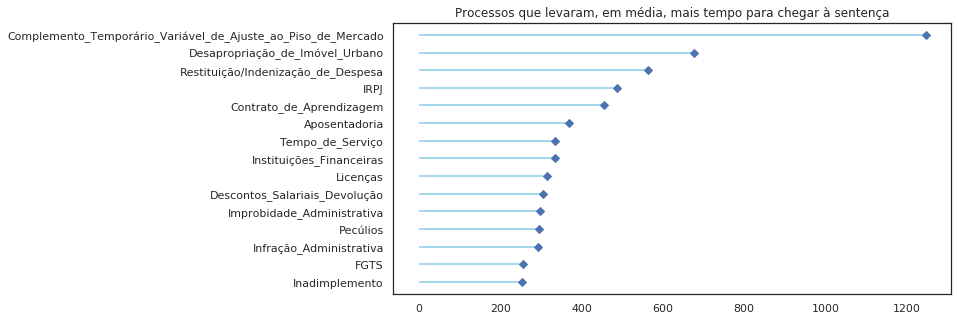

In [0]:
# Seleção das maiores médias 
agr_assunto = julg_assunto.groupby('assunto').mean().astype(int)
agr_assunto = agr_assunto.sort_values(by='dias',ascending=False)[:15]
agr_assunto = agr_assunto.reset_index()

# Gráfico dos processos com as maiores médias de dias entre a data de ajuizamento e a data de sentença
org_plot = agr_assunto.sort_values(by='dias')
plot_range=range(1,len(agr_assunto.index)+1)
 
plt.hlines(y=plot_range, xmin=0, xmax=org_plot['dias'], color='skyblue')
plt.plot(org_plot['dias'], plot_range, "D")
plt.yticks(plot_range, org_plot['assunto'])
plt.title('Processos que levaram, em média, mais tempo para chegar à sentença')
plt.show()


Além disso, também foi elaborado um gráfico para os assuntos que, em média, levaram menos tempo para receber a sentença.

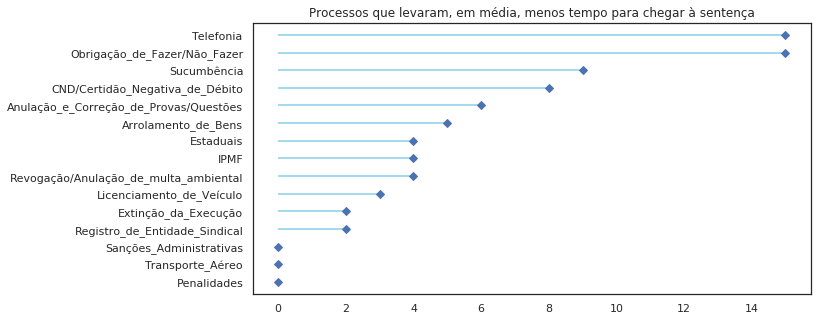

In [0]:
# Seleção das menores médias 
agr_assunto = julg_assunto.groupby('assunto').mean().astype(int)
agr_assunto = agr_assunto.sort_values(by='dias',ascending=True)[:15]
agr_assunto = agr_assunto.reset_index()

# Gráfico dos processos com as menores médias de dias entre a data de ajuizamento e a data de sentença
org_plot = agr_assunto.sort_values(by='dias')
plot_range=range(1,len(agr_assunto.index)+1)

plt.hlines(y=plot_range, xmin=0, xmax=org_plot['dias'], color='skyblue')
plt.plot(org_plot['dias'], plot_range, "D")
plt.yticks(plot_range, org_plot['assunto'])
plt.title('Processos que levaram, em média, menos tempo para chegar à sentença')
plt.show()

## Período entre a data de distribuição e a data de baixa dos processos

Neste segmento, o objeto de estudo passa a ser a frequência do número de dias provenientes dos períodos entre a data de distribuição e a data de baixa do processo.

In [0]:
# Seleção das datas de baixa dos processos
baixa_processo = movimentacoes[movimentacoes['movimentacao'].str.lower().str.contains('arquivo') & 
                                movimentacoes['movimentacao'].str.lower().str.contains('baixa')]
baixa_processo.reset_index(drop=True, inplace=True)

baixa_processo = baixa_processo.rename(columns={'data_movimentacao':'data_baixa'})

baixa_processo = baixa_processo.sort_values(by='data_baixa',ascending=True)
baixa_processo = baixa_processo[~baixa_processo['num_processo'].duplicated()]
baixa_processo.reset_index(drop=True, inplace=True)

In [0]:
# Merge entre 'inicio_processo' e 'baixa_processo'
colunas = ['num_processo','data_distribuicao','data_baixa']
com_baixa = inicio_processo.merge(baixa_processo,on='num_processo', how='inner')[colunas]
com_baixa = com_baixa[~(com_baixa['data_distribuicao']>com_baixa['data_baixa'])]
com_baixa.reset_index(drop=True, inplace=True)

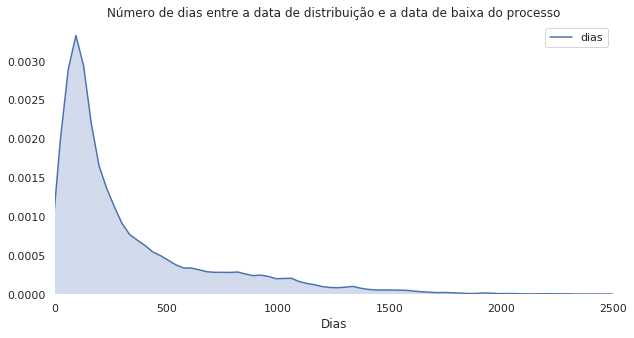

In [0]:
# Subtrair a data de ajuizamento da data de baixa para pegar os dias
julgamento = pd.DataFrame()
julgamento['dias'] = [(i-j).days for i,j in zip(com_baixa['data_baixa'],com_baixa['data_distribuicao'])]

# Gráfico com a distribuição dos dias entre a data de ajuizamento e a data de sentença
sns.set(rc={'figure.figsize':(10,5)})
sns.set_context("notebook")
sns.set_style("white")
sns.kdeplot(julgamento['dias'], shade=True)
plt.xlabel("Dias")
plt.xlim(0,2500)
sns.despine(bottom=True, left=True)
plt.title('Número de dias entre a data de distribuição e a data de baixa do processo')
plt.show()

Como observado acima, tem-se que uma grande parcela dos processos levaram entre 0 e 500 dias para receber baixa.

## Mapa de distribuição dos processos por vara federal do Juizado Especial Federal no Rio Grande do Norte

Com o intuito de visualizar a distribuição dos processos dentre as varas federais do Juizado Especial Federal do Rio Grande do Norte, foi desenvolvido um gráfico do tipo Choropleth, ou mapa coroplético. Esse mapa é característico por representar, com base na intensidade da coloração, a proporcionalidade da variável estatística sendo observada, a qual, nesta análise, é a quantidade de processos por vara federal.

Para a realização disso, foi utilizado um arquivo, de coordenadas dos municípios do RN, proveniente de um projeto que pode ser encontrado neste [link](https://github.com/tbrugz/geodata-br).

In [0]:
# Criação de um dataframe para coleta de processos por vara federal
to_geojson = pd.DataFrame(columns=['cidade', 'numero_processos'])

# Contagem dos processos por vara, atribuindo a todas as cidades envolvidas
transicao = []
aux = 0
for vara in varas['vara']:
  vara = extrair_identificador(vara)
  if vara in transicao:
    continue
  else:
    num = vara_quantidades(varas,vara,transicao)
    for cidade in selecionar_municipios(vara):
      to_geojson.loc[aux, 'cidade'] = cidade
      to_geojson.loc[aux, 'numero_processos'] = num
      aux += 1

In [0]:
# Acessando o arquivo "geojs-24-mun.json"
rn_municipios = os.path.join('geojson', '/content/drive/My Drive/Datasets Extras [IC]/geojs-24-mun.json')

# Carregando os dados com a codificação "latin-1"
geo_json_data = json.load(open(rn_municipios,encoding='latin-1'))

# Criação do mapa
m = folium.Map(
    location=[-5.826592, -35.212558],
    zoom_start=7,
    tiles='Stamen Terrain'
)

# Desenvolvendo o Choropleth
folium.Choropleth(
    geo_data=geo_json_data,
    data=to_geojson,
    columns=['cidade', 'numero_processos'],
    key_on='feature.properties.name',
    fill_color='BuPu',
    legend_name='Número de processos',
    highlight=True,
    line_color = '#00000000'
).add_to(m)

m

## Mapa de distribuição de processos do Juizado Itinerante

In [0]:
# Selecionando apenas os processos associados com o Juizado Itinerante
colunas = ['num_processo','autor','reu','juizado_itinerante','vara_y']
juizado_itinerante = proc_com_varas[proc_com_varas["juizado_itinerante"] == 'S'][colunas]
juizado_itinerante = juizado_itinerante.rename(columns={'vara_y':'vara'})

In [0]:
# Criação de um dataframe para coleta de processos por vara federal
to_geojson = pd.DataFrame(columns=['cidade', 'numero_processos'])

# Contagem dos processos por vara, atribuindo a todas as cidades envolvidas
transicao = []
aux = 0
for vara in juizado_itinerante['vara']:
  vara = extrair_identificador(vara)
  if vara in transicao:
    continue
  else:
    num = vara_quantidades(juizado_itinerante,vara,transicao)
    for cidade in selecionar_municipios(vara):
      to_geojson.loc[aux, 'cidade'] = cidade
      to_geojson.loc[aux, 'numero_processos'] = num
      aux += 1

In [0]:
# Acessando o arquivo "geojs-24-mun.json"
rn_municipios = os.path.join('geojson', '/content/drive/My Drive/Datasets Extras [IC]/geojs-24-mun.json')

# Carregando os dados com a codificação "latin-1"
geo_json_data = json.load(open(rn_municipios,encoding='latin-1'))

# Criação do mapa
m = folium.Map(
    location=[-5.826592, -35.212558],
    zoom_start=7,
    tiles='Stamen Terrain'
)

# Desenvolvendo o Choropleth
folium.Choropleth(
    geo_data=geo_json_data,
    data=to_geojson,
    columns=['cidade', 'numero_processos'],
    key_on='feature.properties.name',
    fill_color='BuPu',
    legend_name='Número de processos',
    highlight=True,
    line_color = '#00000000'
).add_to(m)

m

## Advogados de fora do RN que tem mais de 5 processos por ano

In [0]:
# Função para detectar advogados de fora do RN
def detectar_externo(nome,list_advogados):
  identificadores = ['AC','AL','AP','AM','BA','CE','DF','ES','GO','MA','MT','MS','MG','PA','PB','PR','PE','PI','RJ',
                     'RS','RO','RR','SC','SP','SE','TO']
  try:
    nome_uf = nome.split('(')[1][:2]
    nome_id = adv_id = re.search(r'\((.*?)\)',nome).group(1)
    if nome_uf in identificadores:
      list_advogados.append([nome.split('(')[0].strip(),nome_id,nome_uf])
  except:
    pass

In [0]:
# Dicionário para armazenar os advogados
advogados = []

# Iteração pelos autores e réus, com o objetivo de detectar os advogados de fora do RN
for line in processos['autor'].append(processos['reu']):
  num = 0
  aux = line.split('\n')
  for item in aux:
    detectar_externo(item,advogados)
    
# Transformando o dicionário em dataframe para manipulação posterior    
advogados = pd.DataFrame(advogados,columns=['nome','id','uf']) 

In [0]:
# Retirando duplicatas
advogados = advogados[~advogados.duplicated()].reset_index(drop=True)

In [0]:
# Associando as datas de inicio dos processos com as informações dos mesmos
colunas = ['num_processo','autor','reu','data_distribuicao','ano','mes']
processos_data = processos.merge(inicio_processo,on='num_processo',how='inner')[colunas]

In [0]:
# Agrupando por ano
groups_ano = processos_data.groupby('ano')

In [0]:
selecionados = []

for nome, group in groups_ano:
  for index,row in advogados.iterrows():
    if group[group['autor'].str.contains(row['id']) | group['reu'].str.contains(row['id'])].shape[0] > 5:
      selecionados.append([row['nome'],row['id'],row['uf']])

In [0]:
# Transformando o dicionário em dataframe para manipulação posterior    
selecionados = pd.DataFrame(selecionados,columns=['nome','id','uf']) 

# Retirando duplicatas
selecionados = selecionados[~selecionados.duplicated()].reset_index(drop=True)

In [0]:
# Agrupando por UF
selecionados_groupby = selecionados.groupby('uf').size().reset_index(name='count')

In [0]:
# Gráfico de distribuição de advogados, por unidade federal, que possuem mais de cinco processos por ano
layout = {
    'width': 900,
    'height': 600,
    'xaxis': {
        'categoryorder': 'array',
        'categoryarray': [x for _, x in sorted(zip(selecionados_groupby['count'], selecionados_groupby['uf']))]
    },
    'title' : 'Número de advogados, por unidade federal, que possuem mais de cinco processos por ano'
}

fig = go.FigureWidget(data = [go.Bar(x=selecionados_groupby['uf'], y=selecionados_groupby['count']
                                     ,marker={'color': selecionados_groupby['count'],'colorscale': 'Viridis'})],
                      layout = layout)
fig.update_xaxes(tickangle=45)
fig.show()